# Bipartite Network: Companies and Investors

In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Load and Explore Data

In [2]:
# Load the data
df = pd.read_csv('anonymized_network_data.csv')
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Total rows: 62323

Columns: ['Deal ID', 'Companies', 'Company ID', 'Description_deal', 'Description_investor', 'Primary Industry Sector_deal', 'Primary Industry Group_deal', 'Primary Industry Code_deal', 'Keywords_deal', 'Investors', 'Lead/Sole Investors', 'Primary Investor Type', 'Preferred Industry']


Deal ID        Companies Company ID  \
0  304086-16T    Horizon Drive  CID_00000   
1  303876-37T     Eco Modeling  CID_00001   
2  303464-53T  Meteor TechBase  CID_00002   
3  303125-86T    Blaze Science  CID_00003   
4  303116-68T      Bronze Soft  CID_00004   

                                    Description_deal Description_investor  \
0  Developer of a global healthcare provider sear...                  NaN   
1  Developer and manufacturer of semiconductor pr...                  NaN   
2  Manufacturer of material technologies intended...                  NaN   
3  Developer of large language models designed to...                  NaN   
4  Provider of digital infrastructure tools desig...                  NaN   

           Primary Industry Sector_deal    Primary Industry Group_deal  \
0                            Healthcare  Healthcare Technology Systems   
1                Information Technology                 Semiconductors   
2  Business Products and Services (B2B)            Commercial Products   
3                Information Technology                       Software   
4                Information Technology                       Software   

            Primary Industry Code_deal  \
0  Other Healthcare Technology Systems   
1                 Other Semiconductors   
2        Industrial Supplies and Parts   
3    Software Development Applications   
4       Business/Productivity Software   

                                       Keywords_deal       Investors  \
0  comparison data, digital health solutions, doc...   Joseph Torres   
1  circuit fabrication, processing equipment, sem...     John Wright   
2  composite manufacturers, composite materials, ...  Erik Magnussen   
3  ai capabilities, ai model, ai software develop...    Keith Miller   
4  asset management, content delivery, creative w...    Arvid Morris   

   Lead/Sole Investors Primary Investor Type Preferred Industry  
0                    0                   NaN                NaN  
1                    0                   NaN                NaN  
2                    0                   NaN                NaN  
3                    1                   NaN                NaN  
4                    0                   NaN                NaN

In [3]:
# Check for missing values in key columns
print("Missing values in key columns:")
print(df[['Companies', 'Investors', 'Description_deal', 'Description_investor']].isnull().sum())

Missing values in key columns:
Companies                   0
Investors                   0
Description_deal            0
Description_investor    54233
dtype: int64


## Prepare Node Attributes

In [4]:
# Prepare company attributes
company_attrs = df.groupby('Companies').agg({
    'Description_deal': 'first',
    'Primary Industry Sector_deal': 'first',
    'Primary Industry Group_deal': 'first',
    'Primary Industry Code_deal': 'first'
}).to_dict('index')

print(f"Number of unique companies: {len(company_attrs)}")

Number of unique companies: 13614


In [5]:
# Prepare investor attributes
investor_attrs = df.groupby('Investors').agg({
    'Description_investor': 'first',
    'Lead/Sole Investors': 'sum',  # Sum of lead/sole investments
    'Primary Investor Type': 'first',
    'Preferred Industry': 'first'
}).to_dict('index')

print(f"Number of unique investors: {len(investor_attrs)}")

Number of unique investors: 31753


## Build Bipartite Network

In [6]:
# Create bipartite graph
B = nx.Graph()

# Add company nodes with attributes
for company, attrs in company_attrs.items():
    B.add_node(company, 
               bipartite=0,  # Companies are in set 0
               node_type='company',
               description=attrs['Description_deal'],
               sector=attrs['Primary Industry Sector_deal'],
               industry_group=attrs['Primary Industry Group_deal'],
               industry_code=attrs['Primary Industry Code_deal'])

# Add investor nodes with attributes
for investor, attrs in investor_attrs.items():
    B.add_node(investor,
               bipartite=1,  # Investors are in set 1
               node_type='investor',
               description=attrs['Description_investor'],
               lead_sole_count=attrs['Lead/Sole Investors'],
               investor_type=attrs['Primary Investor Type'],
               preferred_industry=attrs['Preferred Industry'])

print(f"Total nodes: {B.number_of_nodes()}")
print(f"Companies: {len(company_attrs)}")
print(f"Investors: {len(investor_attrs)}")

Total nodes: 45367
Companies: 13614
Investors: 31753


In [7]:
# Count investments (edges with weights)
edge_weights = df.groupby(['Companies', 'Investors']).size().reset_index(name='weight')

# Add weighted edges
for _, row in edge_weights.iterrows():
    B.add_edge(row['Companies'], row['Investors'], weight=row['weight'])

print(f"Total edges: {B.number_of_edges()}")
print(f"\nEdge weight statistics:")
print(edge_weights['weight'].describe())

Total edges: 57395

Edge weight statistics:
count    57395.000000
mean         1.085861
std          0.304594
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: weight, dtype: float64


## Verify Bipartite Structure

In [8]:
# Verify it's bipartite
print(f"Is bipartite: {bipartite.is_bipartite(B)}")

# Get the two sets
companies = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
investors = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

print(f"\nCompany nodes: {len(companies)}")
print(f"Investor nodes: {len(investors)}")

Is bipartite: True

Company nodes: 13614
Investor nodes: 31753


## Network Statistics

In [9]:
# Basic statistics
print("Network Statistics:")
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")
print(f"Density: {nx.density(B):.6f}")
print(f"\nConnected components: {nx.number_connected_components(B)}")

Network Statistics:
Number of nodes: 45367
Number of edges: 57395
Density: 0.000056

Connected components: 3132


In [10]:
# Degree statistics
company_degrees = [B.degree(n) for n in companies]
investor_degrees = [B.degree(n) for n in investors]

print("\nCompany degree statistics (number of investors):")
print(f"Mean: {np.mean(company_degrees):.2f}")
print(f"Median: {np.median(company_degrees):.2f}")
print(f"Max: {np.max(company_degrees)}")
print(f"Min: {np.min(company_degrees)}")

print("\nInvestor degree statistics (number of companies invested in):")
print(f"Mean: {np.mean(investor_degrees):.2f}")
print(f"Median: {np.median(investor_degrees):.2f}")
print(f"Max: {np.max(investor_degrees)}")
print(f"Min: {np.min(investor_degrees)}")


Company degree statistics (number of investors):
Mean: 4.22
Median: 3.00
Max: 128
Min: 1

Investor degree statistics (number of companies invested in):
Mean: 1.81
Median: 1.00
Max: 245
Min: 1


In [11]:
# Top companies by number of investors
top_companies = sorted([(n, B.degree(n)) for n in companies], key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 companies by number of investors:")
for company, degree in top_companies:
    print(f"{company}: {degree} investors")


Top 10 companies by number of investors:
Zen Industries: 128 investors
Vita Future: 63 investors
Orbit District: 60 investors
ZenCore Partners: 53 investors
Inter SolutionsLab: 46 investors
Vanguardis Resources: 46 investors
Orion Comet: 45 investors
Aqua PowerGrid: 44 investors
Turbo Storm: 43 investors
Golden FlowTech: 43 investors


In [12]:
# Top investors by number of companies
top_investors = sorted([(n, B.degree(n)) for n in investors], key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 investors by number of companies:")
for investor, degree in top_investors:
    print(f"{investor}: {degree} companies")


Top 10 investors by number of companies:
Patrick Brooks: 245 companies
Ronald Papadakis: 206 companies
Gabriel Henderson: 185 companies
Kent Dragomir: 155 companies
Tristan Weber: 114 companies
Spencer Perry: 106 companies
Robertson Reed: 104 companies
Jeffrey Ward: 92 companies
Scott Walton: 87 companies
Dylan Galanis: 85 companies


## Visualize Sample Subgraph

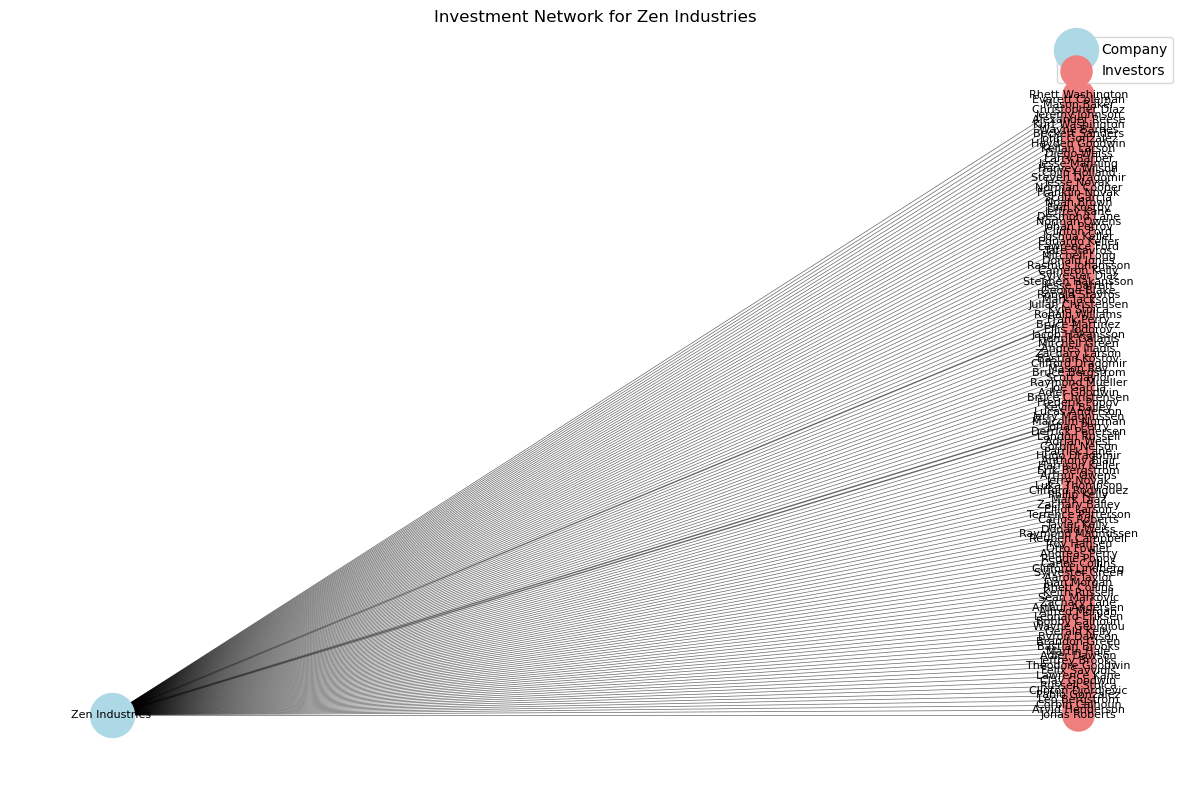

In [13]:
# Visualize a small subgraph (top company and its investors)
if top_companies:
    top_company = top_companies[0][0]
    
    # Get neighbors (investors) of top company
    neighbors = list(B.neighbors(top_company))
    
    # Create subgraph
    subgraph_nodes = [top_company] + neighbors
    subgraph = B.subgraph(subgraph_nodes)
    
    # Create layout
    pos = nx.bipartite_layout(subgraph, [top_company])
    
    # Draw
    plt.figure(figsize=(12, 8))
    
    # Draw company node
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[top_company], 
                          node_color='lightblue', node_size=1000, label='Company')
    
    # Draw investor nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=neighbors,
                          node_color='lightcoral', node_size=500, label='Investors')
    
    # Draw edges with weights
    edges = subgraph.edges()
    weights = [subgraph[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(subgraph, pos, width=[w*0.5 for w in weights], alpha=0.6)
    
    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=8)
    
    plt.title(f"Investment Network for {top_company}")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Save Network

In [15]:
# Save the network
# Convert None values to empty strings for GEXF compatibility
for node, data in B.nodes(data=True):
    for key, value in data.items():
        if value is None:
            B.nodes[node][key] = ""

nx.write_gexf(B, 'bipartite_network.gexf')
print("Network saved as 'bipartite_network.gexf'")

Network saved as 'bipartite_network.gexf'


## Access Node Attributes Example

In [16]:
# Example: Access attributes of a specific company
if top_companies:
    example_company = top_companies[0][0]
    print(f"Attributes for {example_company}:")
    for key, value in B.nodes[example_company].items():
        print(f"  {key}: {value}")

Attributes for Zen Industries:
  bipartite: 0
  node_type: company
  description: Developer of a decentralized blockchain infrastructure protocol designed for interoperability and scalability across multiple blockchain networks. The company's platform enables independent blockchains to exchange data and assets securely through a shared relay chain, supports custom blockchain development via modular frameworks, enabling developers to build and operate interconnected blockchain ecosystems with enhanced security, flexibility, and coordination.
  sector: Information Technology
  industry_group: Software
  industry_code: Software Development Applications


In [17]:
# Example: Access attributes of a specific investor
if top_investors:
    example_investor = top_investors[0][0]
    print(f"\nAttributes for {example_investor}:")
    for key, value in B.nodes[example_investor].items():
        print(f"  {key}: {value}")


Attributes for Patrick Brooks:
  bipartite: 1
  node_type: investor
  description: Founded in 2006, Patrick Brooks is an accelerator/incubator based in Sunnyvale, California. The firm prefers to invest in companies operating in advanced manufacturing, aerospace and defense, agricultural technology, animal health, brand and retail, cryptocurrency and digital assets, deep technology, energy, enterprise and artificial intelligence, financial technology, food and beverage, global overseas acceleration and learning, health, insurance technology, maritime, media and advertising, medical technology, mobility, new materials and packaging, real estate and construction, semiconductors, smart cities, sports technology, supply chain and logistics, sustainability, and travel and hospitality sectors. The firm also makes venture capital investments.
  lead_sole_count: 4
  investor_type: Accelerator/Incubator
  preferred_industry: Aerospace and Defense, Animal Husbandry, Aquaculture, Beverages, Commu

# Investor-Investor Network

Create a network where investors are connected based on co-investments.

## Create the network

In [21]:
# Create investor-investor network using bipartite projection
from networkx.algorithms import bipartite

# Get investor nodes
investor_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# Create weighted projection
I = bipartite.weighted_projected_graph(B, investor_nodes)

print(f"Investor network: {I.number_of_nodes()} nodes, {I.number_of_edges()} edges")

Investor network: 31753 nodes, 231006 edges


In [22]:
# Normalize weights to [0, 1]
weights = [I[u][v]['weight'] for u, v in I.edges()]

if weights:
    min_w, max_w = min(weights), max(weights)
    print(f"Weight range: [{min_w}, {max_w}]")
    
    if max_w > min_w:
        for u, v in I.edges():
            I[u][v]['normalized_weight'] = (I[u][v]['weight'] - min_w) / (max_w - min_w)
    else:
        for u, v in I.edges():
            I[u][v]['normalized_weight'] = 1.0
    
    norm_weights = [I[u][v]['normalized_weight'] for u, v in I.edges()]
    print(f"Normalized: [{min(norm_weights):.3f}, {max(norm_weights):.3f}]")

Weight range: [1, 22]
Normalized: [0.000, 1.000]


In [23]:
# Save investor network
for node, data in I.nodes(data=True):
    for key, value in data.items():
        if value is None:
            I.nodes[node][key] = ""

nx.write_gexf(I, 'investor_network.gexf')
print("Saved as 'investor_network.gexf'")

Saved as 'investor_network.gexf'


## Visualize the network

In [13]:
I = nx.read_gexf('investor_network.gexf')

In [14]:
I.number_of_nodes()

31753

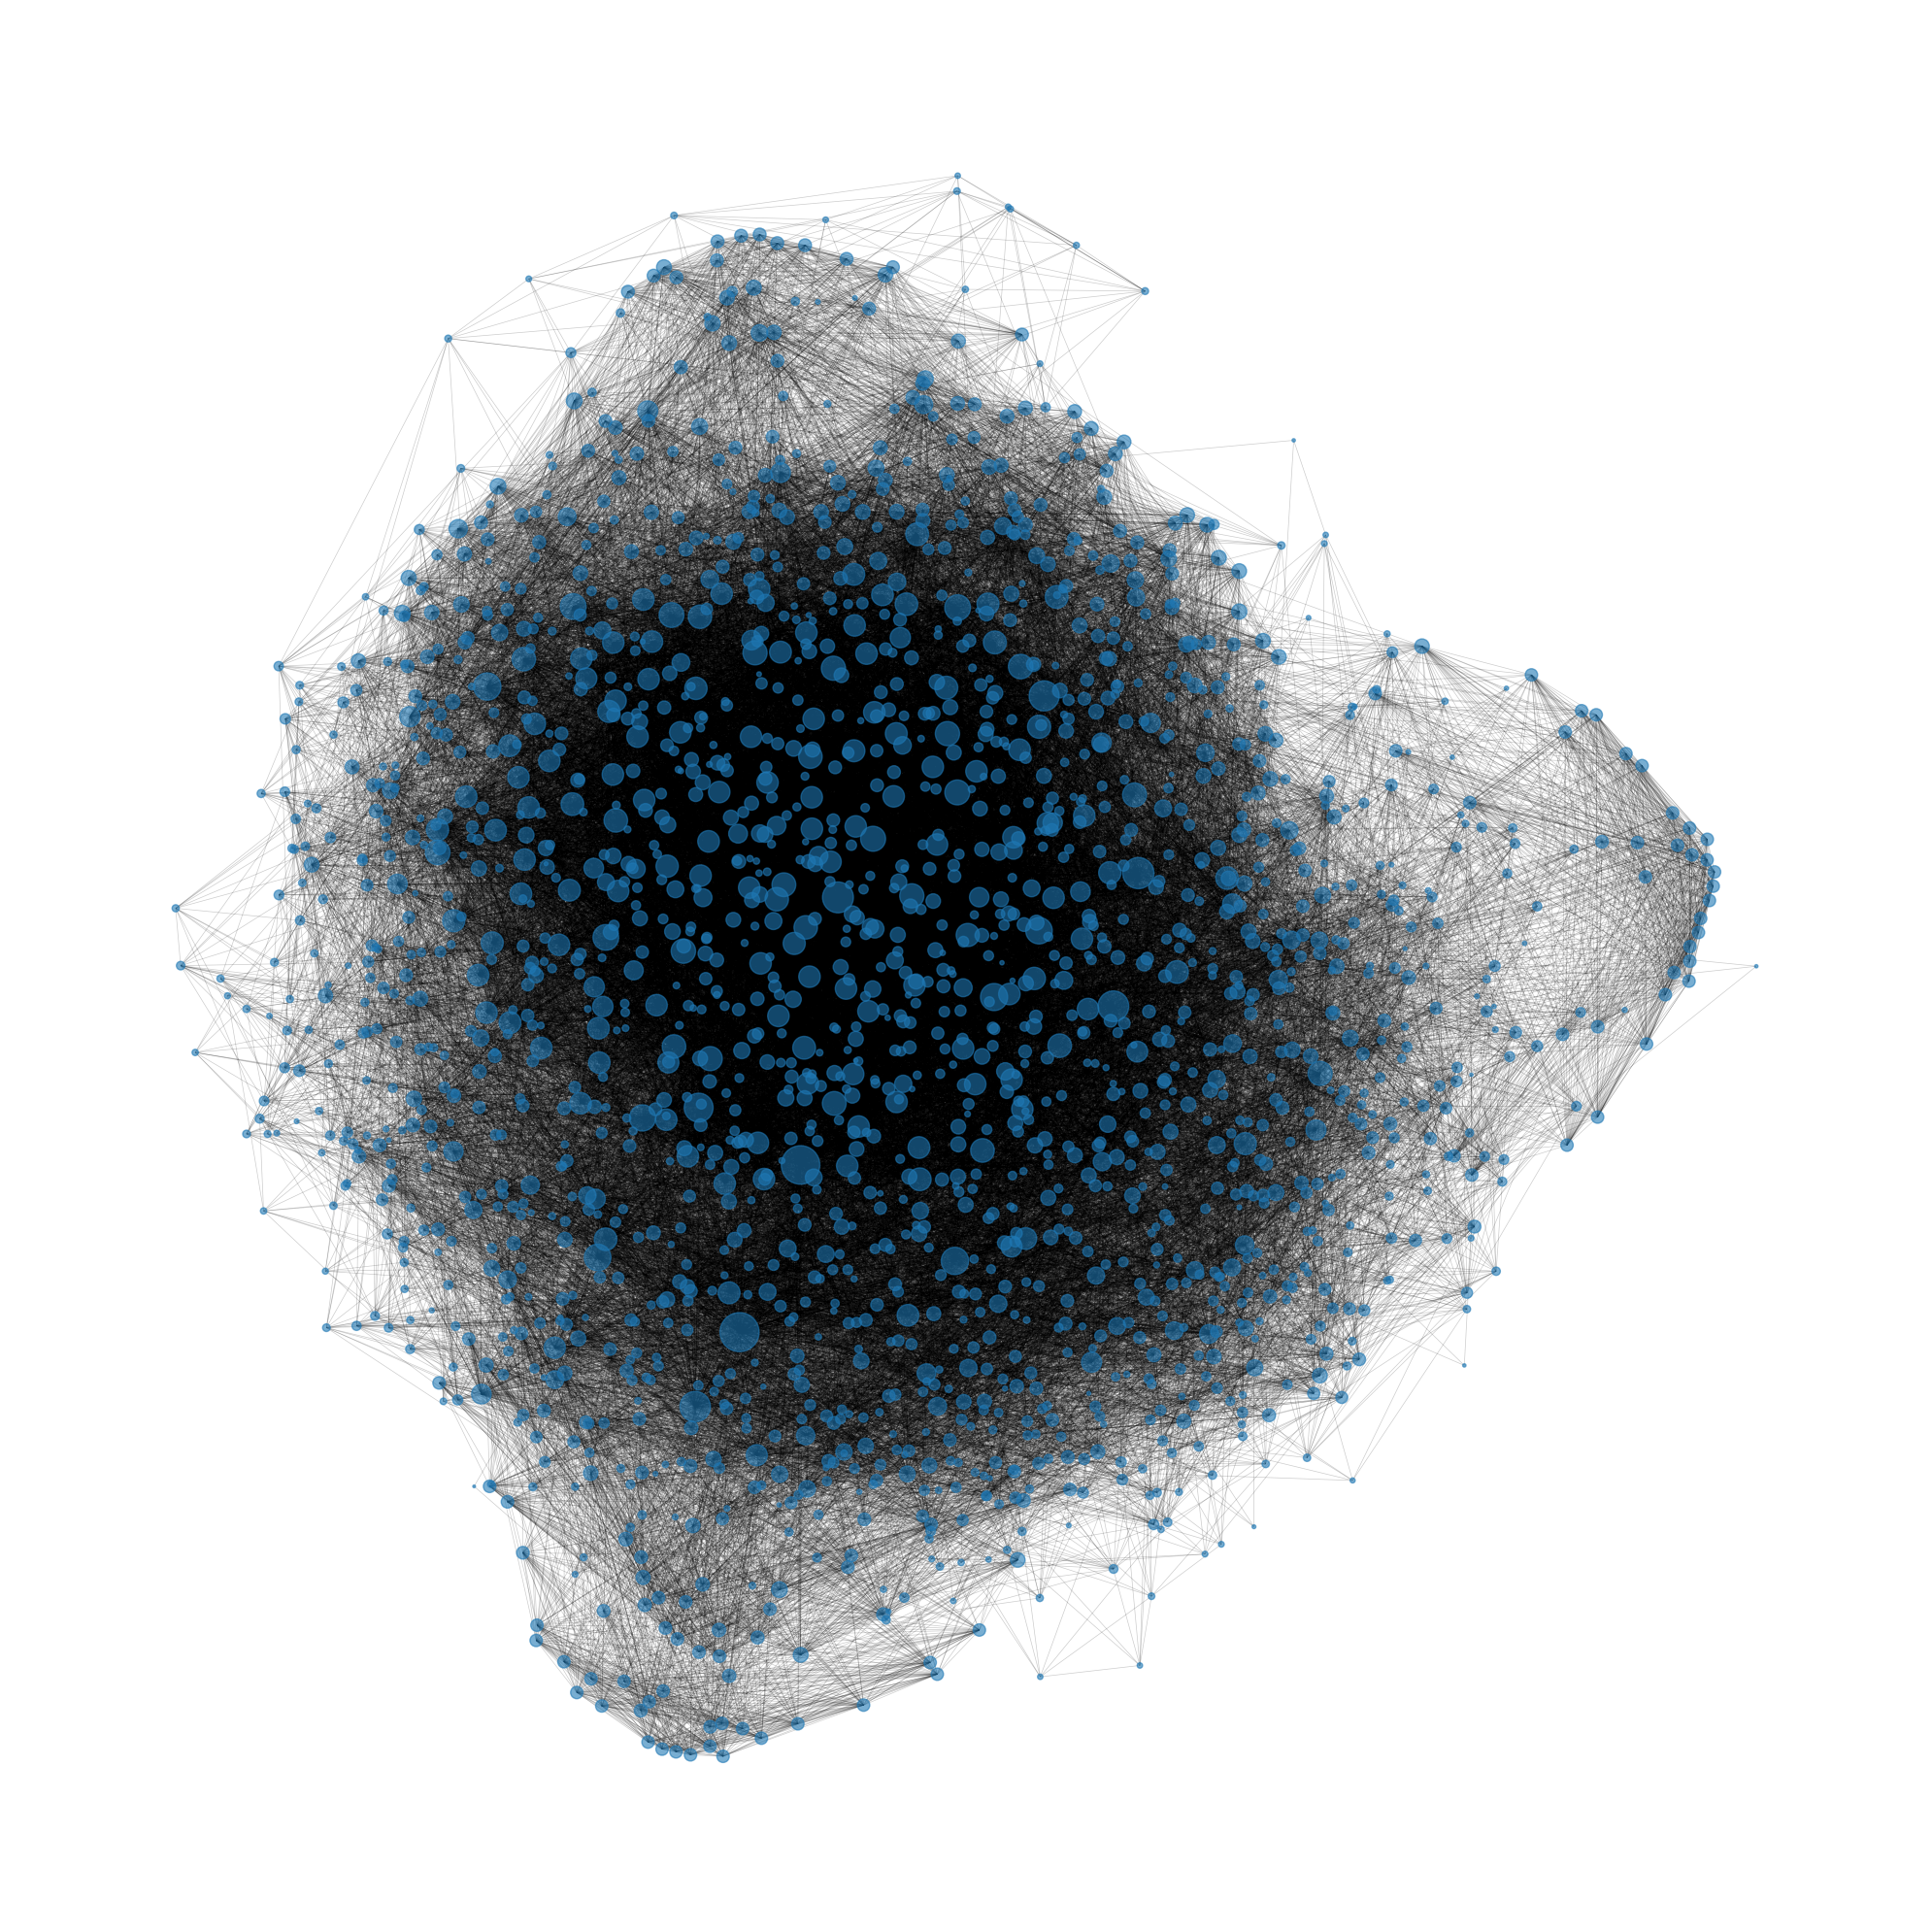

In [15]:
# Option A: Top degree nodes
top_n = 2000
top_nodes = sorted(I.degree(), key=lambda x: x[1], reverse=True)[:top_n]
top_node_names = [node for node, degree in top_nodes]
subgraph = I.subgraph(top_node_names)

# For matplotlib (if you must)
plt.figure(figsize=(20, 20))

# Fast layouts for large graphs:
pos = nx.forceatlas2_layout(subgraph)  # Good quality, slower
# pos = nx.spring_layout(subgraph, k=1, iterations=20)  # Faster

# Calculate node sizes based on degree
node_degrees = dict(subgraph.degree())
node_sizes = [node_degrees[node] * 2 for node in subgraph.nodes()]  # Scale factor of 2

# Draw without labels for speed
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, alpha=0.6)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2, width=0.5)
plt.axis('off')
plt.tight_layout()
plt.savefig('network.png', dpi=150, bbox_inches='tight')


## Community detection

### Communities extracted from Louvain algorithm

Louvain modularity: 0.7161
Genre modularity not found in notebook variables; skipping comparison.
Layout: ForceAtlas2 (fa2) used.


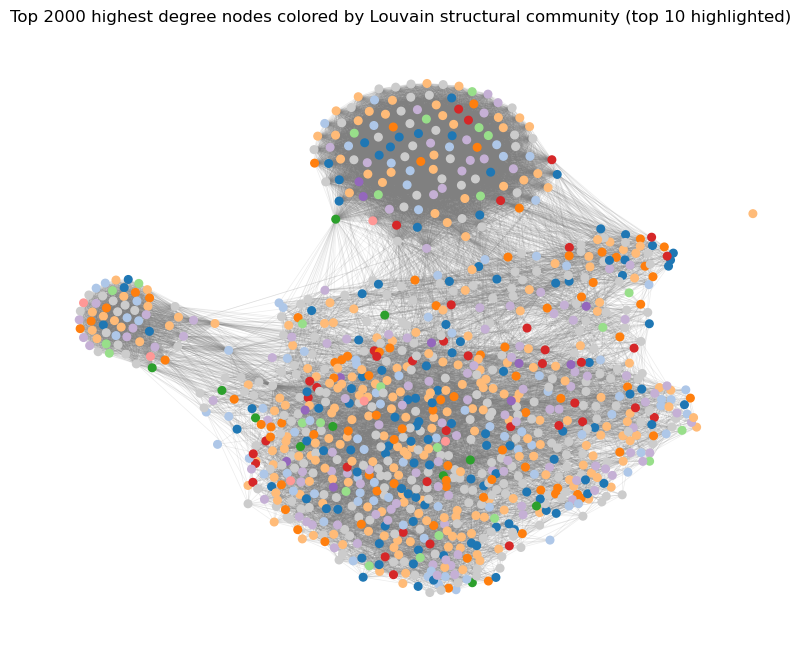

Number of Louvain communities: 3187
Sizes of top communities: [3005, 2922, 1974, 1384, 1282, 1164, 1110, 1089, 1006, 887]

Interpretation hints:
- Higher Louvain modularity compared to genre modularity suggests structural communities align better with graph topology.
- If genre modularity is similar or higher, genres may already capture dense groups in the network.
- Backbone (spanning tree) highlights key bridging edges; check whether backbone edges connect different colored communities (bridges) or stay within communities (intra-community backbones).


In [16]:
from collections import Counter
from networkx.algorithms.community import louvain_communities
from networkx import forceatlas2_layout
import networkx as nx

# Louvain structural communities, modularity, ForceAtlas (or fallback) visualization, and backbone view.
# Relies on notebook variables defined elsewhere: H, modularity_from_communities, _modularity_genres_first

def modularity_from_communities(G_in, communities):
    m_edges = G_in.number_of_edges()
    if m_edges == 0:
        return 0.0
    Q = 0.0
    for C in communities:
        L_c = G_in.subgraph(C).number_of_edges()             # internal edges
        D_c = sum(dict(G_in.degree(C)).values())             # sum of degrees (in G_in)
        Q += (L_c / m_edges) - (D_c / (2 * m_edges)) ** 2
    return Q


import matplotlib.pyplot as plt

# 1) compute Louvain communities (try networkx implementation, fallback to python-louvain)
try:
    louvain_comms = louvain_communities(I, resolution=1, seed=42)
except Exception:
    try:
        import community as community_louvain  # python-louvain
        part = community_louvain.best_partition(H)
        tmp = {}
        for n, c in part.items():
            tmp.setdefault(c, []).append(n)
        louvain_comms = list(tmp.values())
    except Exception as e:
        raise RuntimeError("Louvain community detection not available: " + str(e))

# 2) modularity of Louvain partition (using provided helper)
Q_louvain = modularity_from_communities(I, louvain_comms)
print(f"Louvain modularity: {Q_louvain:.4f}")

# compare to genre-based modularity if available
if "_modularity_genres_first" in globals():
    Q_genre = _modularity_genres_first
    print(f"Genre (first-genre) modularity: {Q_genre:.4f}")
    if Q_louvain > Q_genre:
        print("Louvain partition is more community-like (higher modularity) than genres.")
    elif Q_louvain < Q_genre:
        print("Genres produce higher modularity than Louvain partition.")
    else:
        print("Modularity is equal for Louvain and genre partition (within numerical precision).")
else:
    print("Genre modularity not found in notebook variables; skipping comparison.")

# 3) prepare coloring for visualization: color top K largest communities, rest gray
comm_sizes = sorted([(i, len(c)) for i, c in enumerate(louvain_comms)], key=lambda x: -x[1])
top_k = 10
top_comm_idxs = [i for i, _ in comm_sizes[:top_k]]

node_to_comm = {}
for idx, comm in enumerate(louvain_comms):
    for n in comm:
        node_to_comm[n] = idx

# map nodes to colors
cmap = plt.get_cmap("tab20")
colors = {}
for i, comm_idx in enumerate(top_comm_idxs):
    colors[comm_idx] = cmap(i % 20)
# default color for small communities
default_color = (0.8, 0.8, 0.8)

# 4) select top 1000 nodes by degree
degrees = dict(I.degree())
top_1000_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:1000]
top_1000_subgraph = I.subgraph(top_1000_nodes)
node_colors = [colors.get(node_to_comm.get(n, None), default_color) for n in top_1000_nodes]

# 5) compute layout: use forceatlas2_layout imported from networkx if available, else spring_layout
pos = None
try:
    pos = forceatlas2_layout(
                                top_1000_subgraph,
                                pos=None, 
                                max_iter=2000, 
                                gravity=0.3, 
                                strong_gravity=True, 
                                jitter_tolerance=0.5,
                                seed=42
    )
    print("Layout: ForceAtlas2 (fa2) used.")
except Exception:
    pos = nx.spring_layout(top_1000_subgraph, seed=42, k=0.1, iterations=200)
    print("Layout: networkx spring_layout used (ForceAtlas2 unavailable).")

# 6) draw top 1000 nodes colored by community (highlighting top K communities)
plt.figure(figsize=(10, 8))
# draw edges faintly
nx.draw_networkx_edges(top_1000_subgraph, pos, alpha=0.15, edge_color="gray", width=0.5)
# draw nodes
nx.draw_networkx_nodes(top_1000_subgraph, pos,
                       node_color=node_colors,
                       node_size=30)
plt.axis('off')
plt.title(f"Top 2000 highest degree nodes colored by Louvain structural community (top {top_k} highlighted)")
plt.show()

# # 7) backbone: try maximum spanning tree (if weights exist, uses 'weight'; otherwise unweighted)
# try:
#     # ensure we operate on an undirected simple Graph
#     if top_1000_subgraph.is_directed():
#         G = top_1000_subgraph.to_undirected(reciprocal=False)
#     else:
#         G = top_1000_subgraph.copy()

#     # If it's a MultiGraph, collapse multiple edges into a simple Graph,
#     # keeping the maximum weight when present (fallback weight=1.0).
#     if G.is_multigraph():
#         G_simple = nx.Graph()
#         for u, v, data in G.edges(data=True):
#             w = data.get('weight', 1.0)
#             if G_simple.has_edge(u, v):
#                 if w > G_simple[u][v].get('weight', float('-inf')):
#                     G_simple[u][v]['weight'] = w
#             else:
#                 attr = dict(data)
#                 attr['weight'] = w
#                 G_simple.add_edge(u, v, **attr)
#         G = G_simple

#     # compute maximum spanning tree on the undirected Graph
#     if any('weight' in d for _, _, d in G.edges(data=True)):
#         backbone = nx.maximum_spanning_tree(G, weight='weight')
#     else:
#         backbone = nx.maximum_spanning_tree(G)  # unweighted
#     print(f"Backbone edges: {backbone.number_of_edges()} (nodes: {backbone.number_of_nodes()})")
# except Exception as e:
#     backbone = None
#     print("Could not compute backbone spanning tree:", e)

# # 8) visualize backbone over colored nodes
# plt.figure(figsize=(10, 8))
# # draw all nodes lightly
# nx.draw_networkx_nodes(top_1000_subgraph, pos, node_color=node_colors, node_size=30)
# # draw full network faint edges
# nx.draw_networkx_edges(top_1000_subgraph, pos, alpha=0.05, edge_color="lightgray", width=0.5)
# # overlay backbone edges thicker and darker if available
# if backbone is not None:
#     nx.draw_networkx_edges(backbone, pos, edge_color="black", width=1.2, alpha=0.9)
#     plt.title("Backbone (maximum spanning tree) over structural communities - Top 1000 nodes")
# else:
#     plt.title("Backbone unavailable — showing top 1000 nodes colored by community")
# plt.axis('off')
# plt.show()

# 9) short quantitative summary of communities
num_comms = len(louvain_comms)
sizes = sorted([len(c) for c in louvain_comms], reverse=True)
print(f"Number of Louvain communities: {num_comms}")
print(f"Sizes of top communities: {sizes[:10]}")

# 10) brief suggested interpretation (printed)
print("\nInterpretation hints:")
print("- Higher Louvain modularity compared to genre modularity suggests structural communities align better with graph topology.")
print("- If genre modularity is similar or higher, genres may already capture dense groups in the network.")
print("- Backbone (spanning tree) highlights key bridging edges; check whether backbone edges connect different colored communities (bridges) or stay within communities (intra-community backbones).")

### Communities based on Industry 

#### Extract industries

In [24]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# Read the data
df = pd.read_csv('anonymized_network_data.csv')

# Create a dictionary to store industry investments for each investor
investor_industries = defaultdict(lambda: defaultdict(int))

# Filter out rows with missing data
valid_data = df.dropna(subset=['Primary Industry Sector_deal', 'Investors'])

# Process the data using vectorized operations
for industry, investor in zip(valid_data['Primary Industry Sector_deal'], valid_data['Investors']):
    investor_industries[investor][industry] += 1

# Convert defaultdict to regular dict for each investor
for investor in investor_industries:
    investor_industries[investor] = dict(investor_industries[investor])

# Add the industry_investments attribute to investor nodes
for node in I.nodes():
    if node in investor_industries:
        I.nodes[node]['industry_investments'] = investor_industries[node]
    else:
        I.nodes[node]['industry_investments'] = {}


In [ ]:
import networkx as nx

nx.write_gexf(I, "investor_network.gexf")

#### Communities on industries

In [62]:
# Create communities based on industries
industry_communities = {}

# Get all unique industries from all investors
all_industries = set()
for node in I.nodes():
    if 'industry_investments' in I.nodes[node]:
        all_industries.update(I.nodes[node]['industry_investments'].keys())

# Create a community for each industry
for industry in all_industries:
    industry_communities[industry] = []
    for node in I.nodes():
        if 'industry_investments' in I.nodes[node]:
            if industry in I.nodes[node]['industry_investments']:
                industry_communities[industry].append(node)

# Print community information
for industry, members in industry_communities.items():
    print(f"Industry: {industry}")
    print(f"Number of investors: {len(members)}")
    print(f"Members: {members[:10]}...")  # Show first 10 members
    print()


Industry: Financial Services
Number of investors: 2359
Members: ['Beckett Reese', 'Henry Barnes', 'Markus Casey', 'Gerald Kelly', 'Torben Russell', 'Logan Taylor', 'Ronald Ivanov', 'Zane Wood', 'Rory Jordan', 'Patrick Nelson']...

Industry: Energy
Number of investors: 1140
Members: ['Max King', 'Jesse Fowler', 'Shawn Lindberg', 'Reggie Owens', 'Mark Rogers', 'Billy Lopez', 'Paul Gray', 'Byron Bishop', 'Kent Campbell', 'Oscar Taylor']...

Industry: Information Technology
Number of investors: 17427
Members: ['Adrian Turner', 'Beckett Reese', 'Cole Krause', 'Henry Barnes', 'Markus Casey', 'Franklin Gonzalez', 'Gerald Kelly', 'Walter Whitaker', 'Philip Brandt', 'Brayden Graham']...

Industry: Healthcare
Number of investors: 6077
Members: ['Bryan Alexander', 'Nathan White', 'Bastian Galanis', 'Markus Casey', 'Tate Anderson', 'Johnny Madsen', 'George Cox', 'Seth French', 'Clay Lund', 'Erik Hoffman']...

Industry: Materials and Resources
Number of investors: 1377
Members: ['Albert Russell', '

In [67]:
import networkx as nx

# Calculate modularity of the communities
modularity = modularity_from_communities(I, industry_communities.values())
print(f"Modularity: {modularity:.4f}")


Modularity: 0.4318


## NLP for community focus